In [26]:
%pip install -qq -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip -qq install mlrun s3fs seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dbt-common 1.10.0 requires protobuf<5.0.0,>=4.0.0, but you have protobuf 3.20.3 which is incompatible.
dbt-core 1.8.8 requires protobuf<5,>=4.0.0, but you have protobuf 3.20.3 which is incompatible.


In [53]:
import pandas as pd
from datasets_tourism import *
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
START_DATE = "2022-01-01"
END_DATE = "2023-12-31"

# Dati Vodafone

**In vodafone data, first find the locId of locations that are relevant for the "Molveno" use case**
- LAGO_MOLV Lago di Molveno
- 27        Molveno
- 166       Andalo
- 105       Altopiano Paganella ecc..

In [26]:
locId_LAGO_MOLVENO = "LAGO_MOLV"
locId_MOLVENO = "27"
locId_ANDALO = "166"
locID_ALTOPIANO_APT = "105" # Altopiano della Paganella, Rotaliana e San Lorenzo Dorsino

In [33]:
vodafone_lagomolveno = vodafone_attendences_ALL_df[
    (vodafone_attendences_ALL_df["locId"] == locId_LAGO_MOLVENO) & 
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]
vodafone_andalo = vodafone_attendences_ALL_df[
    (vodafone_attendences_ALL_df["locId"] == locId_ANDALO) &
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]
vodafone_apt = vodafone_attendences_ALL_df[
    (vodafone_attendences_ALL_df["locId"] == locID_ALTOPIANO_APT) &
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]

In [34]:
vodafone_apt

,date,locType,locId,userCountry,userProfile,userCluster,value
4621,2022-01-01,TN_MKT_AM_22,105,ALB,TOURIST,None,115
4622,2022-01-01,TN_MKT_AM_22,105,ALB,VISITOR,None,0
4623,2022-01-01,TN_MKT_AM_22,105,ARE,VISITOR,None,0
4624,2022-01-01,TN_MKT_AM_22,105,ARG,TOURIST,None,0
4625,2022-01-01,TN_MKT_AM_22,105,AUS,VISITOR,None,0
...,...,...,...,...,...,...,...
4855006,2023-12-30,TN_MKT_AM_22,105,STR,TOURIST,STR,2742
4855007,2023-12-30,TN_MKT_AM_22,105,STR,VISITOR,STR,869
4855386,2023-12-31,TN_MKT_AM_22,105,STR,COMMUTER,STR,38
4855387,2023-12-31,TN_MKT_AM_22,105,STR,TOURIST,STR,2644


In [35]:
vodafone_apt_tourists = vodafone_apt[vodafone_apt["userProfile"] == "TOURIST"].groupby("date").sum().reset_index()[["date", "value"]]

In [82]:
vodafone_apt_tourists["date"] = pd.to_datetime(vodafone_apt_tourists["date"])
vodafone_apt_tourists.dtypes

date     datetime64[ns]
value             int64
dtype: object

# Movimento turistico APT

## Daily granularity (2022- 2023)

In [131]:
concat_df = pd.concat([vodafone_apt_tourists.set_index("date"), movimento_turistico_df.set_index("giorno")], axis=1).reset_index()
concat_df = concat_df[["index", "value", "presenze"]].rename(columns={"value": "presenze_turistiche_vodafone", "presenze": "movimento_turistico", "index": "date"})
concat_df

,date,presenze_turistiche_vodafone,movimento_turistico
0,2022-01-01,20990,9433
1,2022-01-02,21809,8585
2,2022-01-03,17891,8712
3,2022-01-04,17117,8534
4,2022-01-05,16830,8464
...,...,...,...
725,2023-12-27,16482,8765
726,2023-12-28,17971,9418
727,2023-12-29,19553,9996
728,2023-12-30,21372,10525


<Axes: xlabel='giorno'>

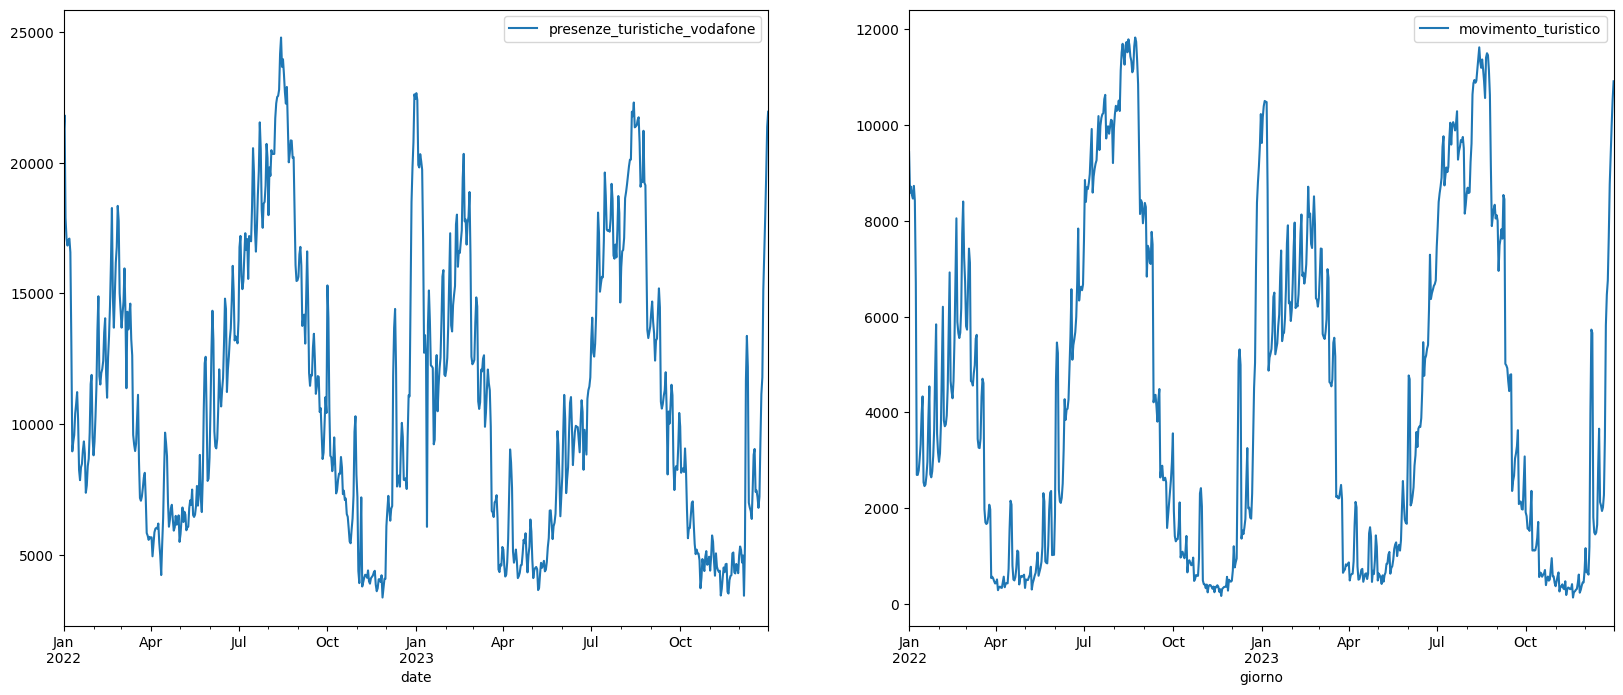

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
vodafone_apt_tourists.plot(x="date", y="value", label="presenze_turistiche_vodafone", ax=axes[0])
movimento_turistico_df.plot(y="presenze", x="giorno", label="movimento_turistico", ax=axes[1])
#sns.histplot(vodafone_apt_tourists, x="value", ax=axes[1, 0], label="vodafone")
#sns.histplot(concat_df, x="presenze_turistiche", ax=axes[1, 0], label="movimento_turistico")

<Axes: xlabel='date'>

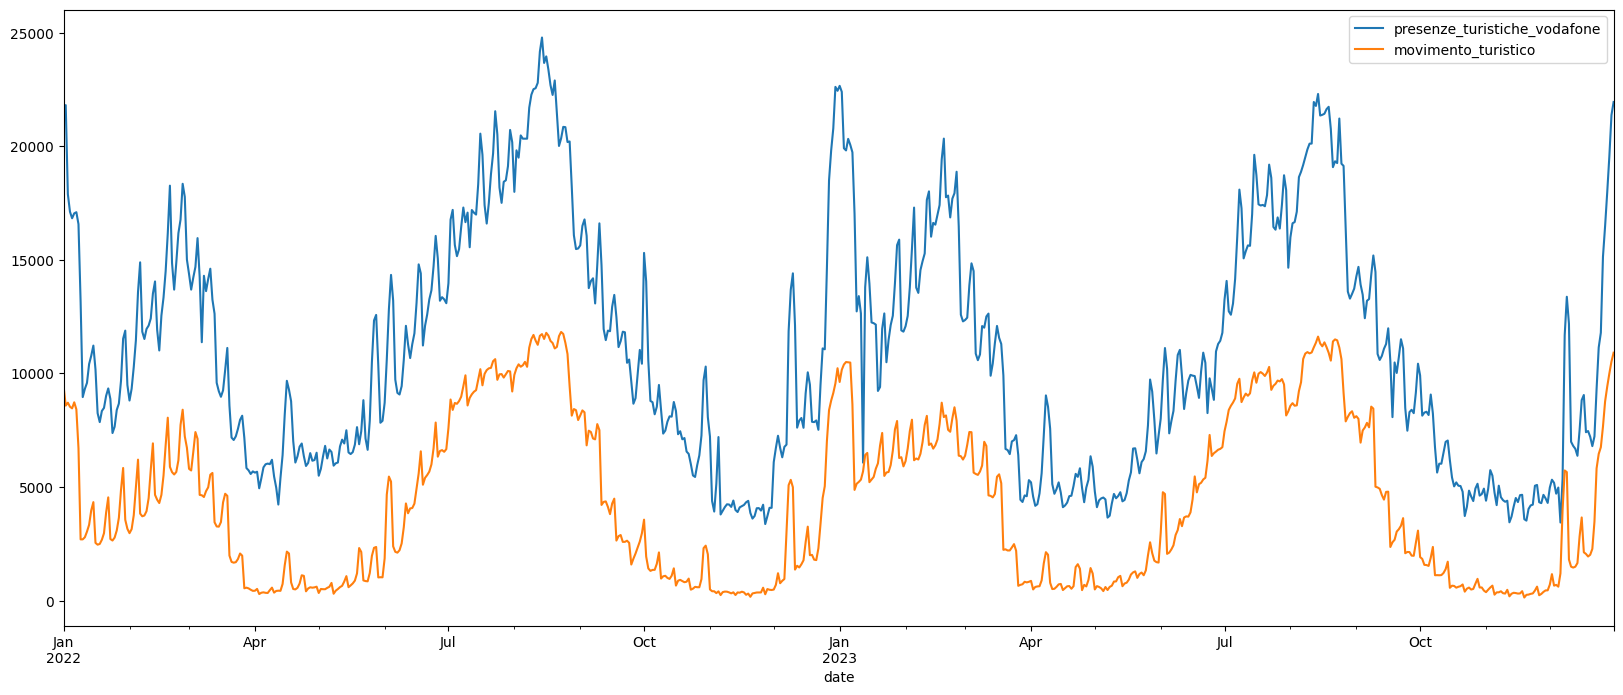

In [133]:
concat_df.plot(x="date", figsize=(20, 8))

In [88]:
movimento_turistico_df.describe()

,giorno,arrivi,presenze
count,730,730.000000,730.000000
mean,2022-12-31 12:00:00,1066.556164,4352.626027
min,2022-01-01 00:00:00,28.000000,137.000000
25%,2022-07-02 06:00:00,291.250000,883.500000
50%,2022-12-31 12:00:00,791.000000,3414.000000
75%,2023-07-01 18:00:00,1406.000000,7422.750000
max,2023-12-31 00:00:00,6236.000000,11826.000000
std,NaN,1018.508473,3572.490345


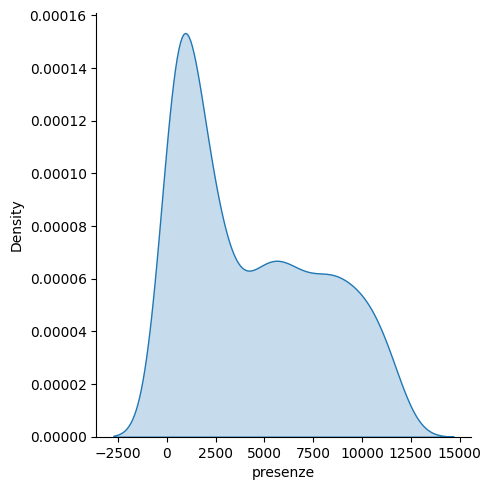

In [137]:
sns.displot(movimento_turistico_df, x="presenze", kind="kde", fill=True)

In [114]:
vodafone_apt_tourists.describe()

,date,value
count,730,730.000000
mean,2022-12-31 12:00:00,11010.524658
min,2022-01-01 00:00:00,3370.000000
25%,2022-07-02 06:00:00,6462.750000
50%,2022-12-31 12:00:00,10185.500000
75%,2023-07-01 18:00:00,14835.250000
max,2023-12-31 00:00:00,24785.000000
std,NaN,5298.739984


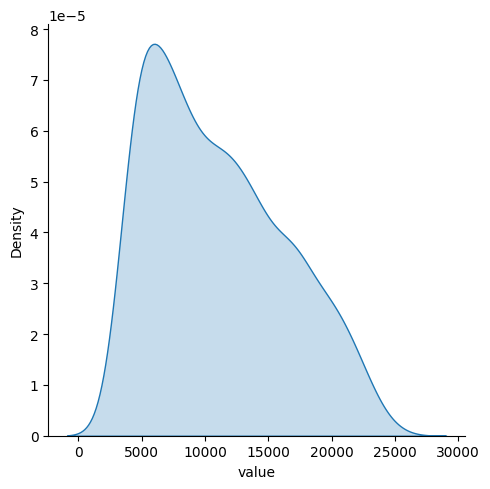

In [119]:
sns.displot(vodafone_apt_tourists, x="value", kind="kde", fill=True)

<Axes: ylabel='Density'>

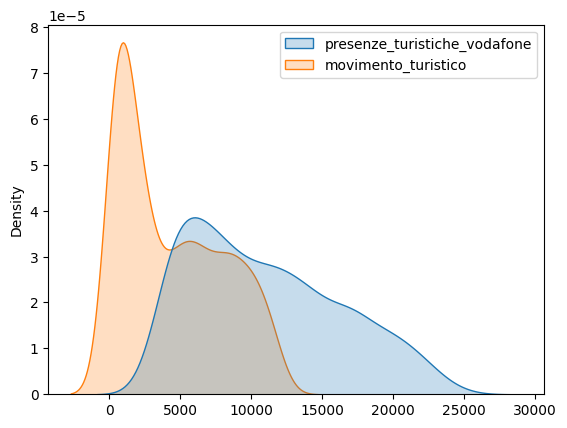

In [138]:
sns.kdeplot(data=concat_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True)

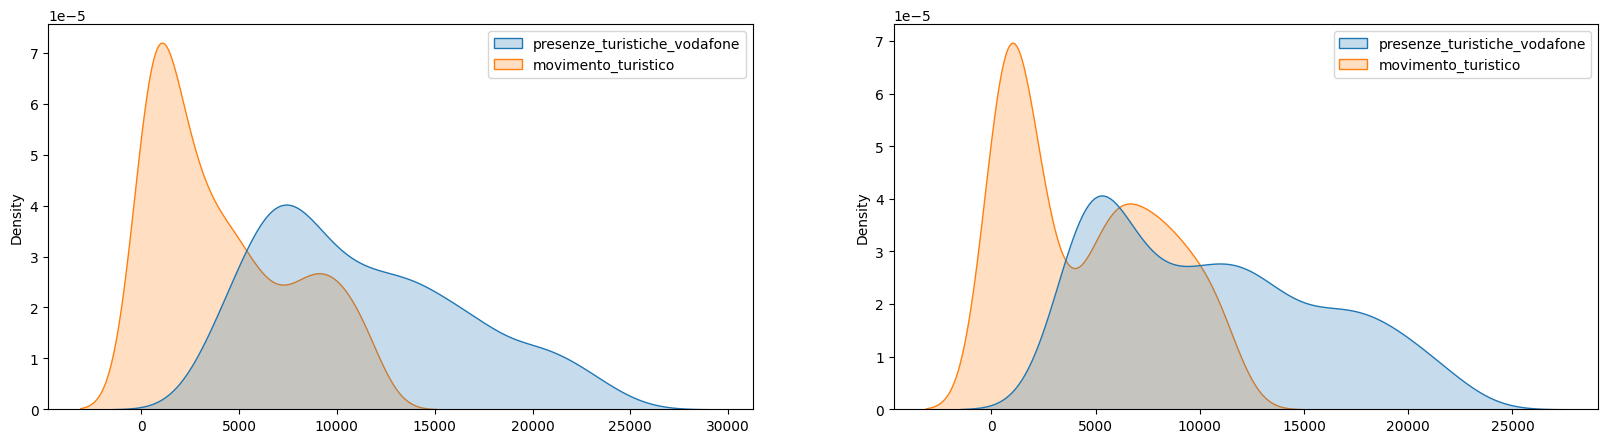

In [158]:
presences_2022_df = concat_df[(concat_df["date"] >= "2022-01-01") & (concat_df["date"] <= "2022-12-31")]
presences_2023_df = concat_df[(concat_df["date"] >= "2023-01-01") & (concat_df["date"] <= "2023-12-31")]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.kdeplot(data=presences_2022_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True, label=["2022"], ax=axes[0])
sns.kdeplot(data=presences_2023_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True, ax=axes[1])
plt.show()

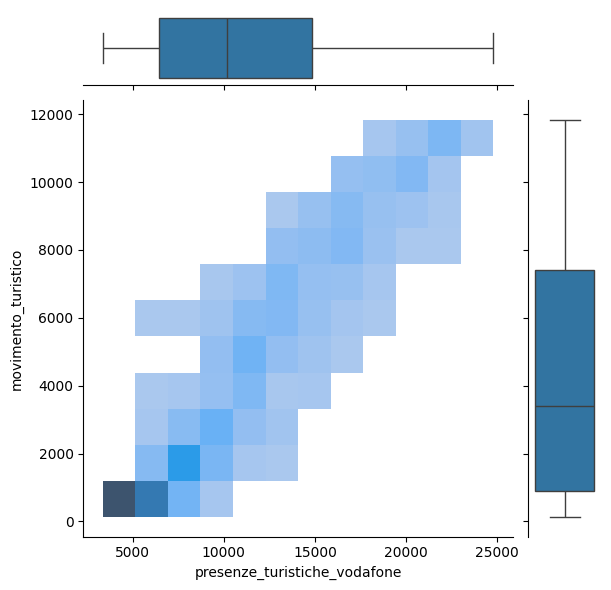

In [169]:
g = sns.JointGrid(data=concat_df, x="presenze_turistiche_vodafone", y="movimento_turistico")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

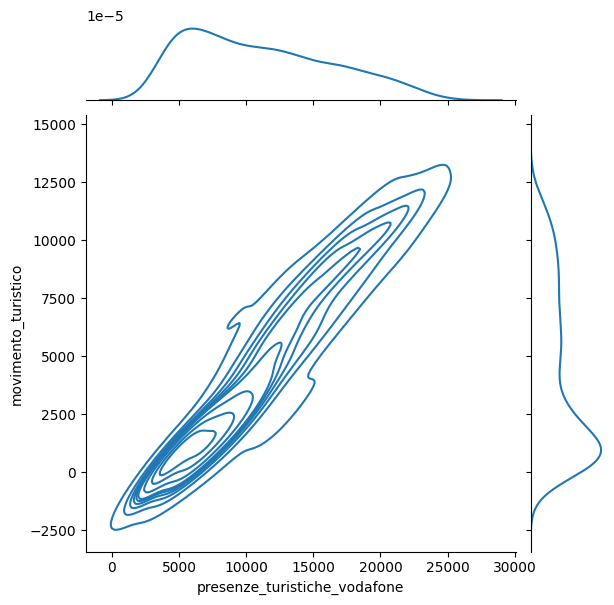

In [171]:
sns.jointplot(
    data=concat_df,
    x="presenze_turistiche_vodafone", y="movimento_turistico",
    kind="kde"
)

## ISPAT Monthly granularity

In [218]:
monthly_movimento_tourists = pd.read_csv("data/ambito_paganella.csv")
monthly_movimento_tourists.columns = ['month', 'value_extra_alberghieri', 'value_alberghieri']
monthly_movimento_tourists["tot_turisti"] = monthly_movimento_tourists["value_extra_alberghieri"].add(monthly_movimento_tourists["value_alberghieri"])
vodafone_2023 = vodafone_attendences_ALL_df[
    (vodafone_attendences_ALL_df["locId"] == locID_ALTOPIANO_APT) &
    (vodafone_attendences_ALL_df["date"] >= "2023-01-01") &
    (vodafone_attendences_ALL_df["date"] <= "2023-12-31")
]
vodafone_2023["date"] = pd.to_datetime(vodafone_2023["date"])
vodafone_2023["month"] = vodafone_2023["date"].dt.month
vodafone_2023 = vodafone_2023[vodafone_2023["userProfile"] == "TOURIST"][["month", "value"]].groupby("month").sum().reset_index()[["month", "value"]]
concat_monthly = pd.concat([monthly_movimento_tourists.set_index("month"), vodafone_2023.set_index("month")], axis=1).reset_index()
concat_monthly = concat_monthly[["month", "tot_turisti", "value"]].rename(columns={"tot_turisti": "movimento_turistico", "value": "presenze_turistiche_vodafone"})
concat_monthly


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,month,movimento_turistico,presenze_turistiche_vodafone
0,1,205252,445337
1,2,194805,450571
2,3,118269,296929
3,4,17159,161215
4,5,18075,174005
5,6,120510,292566
6,7,257604,508452
7,8,280860,584761
8,9,120918,338757
9,10,22395,187825


<Axes: xlabel='month'>

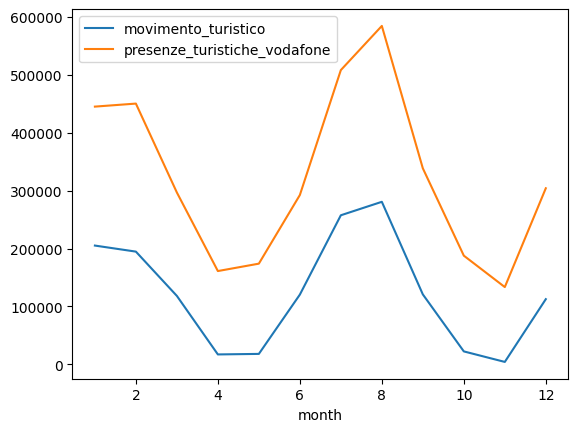

In [219]:
concat_monthly.plot(x="month")

In [200]:
sns.histplot(monthly_movimento_tourists, x="value", y="month", kind="kde", fill=True)

ValueError: Could not interpret value `value` for `x`. An entry with this name does not appear in `data`.

# Movimento turistico Molveno

In [23]:
movimento_turistico_molveno_df

,anno,mese,date,territorio_comunale,arrivi,presenze
0,2022,01,2022-01-01,MOLVENO,303,2102
1,2022,01,2022-01-02,MOLVENO,829,1783
2,2022,01,2022-01-03,MOLVENO,479,1787
3,2022,01,2022-01-04,MOLVENO,209,1748
4,2022,01,2022-01-05,MOLVENO,320,1649
...,...,...,...,...,...,...
725,2023,12,2023-12-27,MOLVENO,606,1494
726,2023,12,2023-12-28,MOLVENO,581,1802
727,2023,12,2023-12-29,MOLVENO,725,2138
728,2023,12,2023-12-30,MOLVENO,855,2371
